In [1]:
import pandas as pn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [24]:
sys.path.append("../..")
import gempy
import theano

In [57]:
geo_data.extent

array([-250000., 1450000., 6000000., 7800000.,   -8000.,       0.])

In [65]:
 # Importing the data from csv files and settign extent and resolution
geo_data = gempy.read_pickle("/home/miguel/PycharmProjects/gempy/test/input_data/geo_data.pickle")
geo_data.interfaces['formation'] = geo_data.interfaces['formation'].astype('category')
geo_data.orientations['formation'] = geo_data.orientations['formation'].astype('category')
geo_data.add_orientation(X=-2.88043478e+04, Y=6.21413043e+06, Z=-1.17648965e+02, dip=0, azimuth=0, polarity=1,
                         formation='basement')
geo_data.faults_relations = None
new_grid = gempy.GridClass()
res = 100

# Create a new grid object with the new resolution
new_grid.set_regular_grid([-250000., 1450000., 6000000., 7800000.,   -80000.,  10000.],
                          [res, res, res])

# Setting the new grid to the geodata
gempy.set_grid(geo_data, new_grid)

n_faults = 0

In [66]:
geo_data.orientations['formation_number'] = 1

In [70]:
geo_data.update_df()


In [45]:
interp_data = gempy.InterpolatorData(geo_data, dtype='float32', compile_theano=True, verbose=[],
                                     theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float32
Number of faults:  0


In [71]:
interp_data.update_interpolator(geo_data)

In [72]:
interp_data.interpolator.tg.nugget_effect_grad_T.set_value(0)
interp_data.interpolator.tg.nugget_effect_scalar_T.set_value(0)

In [73]:
interp_data.interpolator.tg.grid_val_T.get_value()

array([[0.2701    , 0.2526352 , 0.47881833],
       [0.2701    , 0.2526352 , 0.47907186],
       [0.2701    , 0.2526352 , 0.47932535],
       ...,
       [0.556438  , 0.2641845 , 0.50105107],
       [0.556438  , 0.2641845 , 0.50105107],
       [0.556438  , 0.2641845 , 0.50105107]], dtype=float32)

In [74]:
lith, fault = gempy.compute_model(interp_data)

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.211262e-09
  rval = scipy.linalg.solve(A, b)


In [49]:
lith.shape

(2, 1000000)

In [27]:


interp_data.interpolator.tg.fault_matrix = theano.tensor.zeros((n_faults * 2,
                                                                interp_data.interpolator.tg.grid_val_T.shape[0] +
                                                                2 * interp_data.interpolator.tg.len_points))
theano.config.optimizer = 'fast_run'


In [28]:
th_f = theano.function(interp_data.interpolator.tg.input_parameters_list(),
                       interp_data.interpolator.tg.compute_a_series(
                           *interp_data.interpolator.tg.len_series_i.get_value()[n_faults:].astype(int),
                           *interp_data.interpolator.tg.len_series_f.get_value()[n_faults:].astype(int),
                           *interp_data.interpolator.tg.n_formations_per_serie.get_value()[n_faults:],
                           *interp_data.interpolator.tg.n_universal_eq_T.get_value()[n_faults:],
                           interp_data.interpolator.tg.lith_block_init,
                           interp_data.interpolator.tg.final_scalar_field_at_formations_op,
                          # interp_data.interpolator.tg.fault_matrix
                       ),
                       on_unused_input='ignore',
                       allow_input_downcast=True,
                       profile=False)

In [29]:
sol = th_f(*interp_data.get_input_data())



/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.205290e-09
  rval = scipy.linalg.solve(A, b)


In [36]:
sol[1]

array([40.653664], dtype=float32)

In [40]:
interp_data.potential_at_interfaces = np.array([sol[1]])

In [76]:
ver, sim = gp.get_surfaces(interp_data, lith[1], None, original_scale=True)
gempy.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/slinalg.py:255: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.105976e-08
  rval = scipy.linalg.solve(A, b)


closing vtk


In [52]:
%debug

> /home/miguel/PycharmProjects/gempy/gempy/plotting/visualization.py(862)create_foliation()
    860         d.SetNormal(Gx, Gy, Gz)
    861         d.SetCenter(X, Y, Z)
--> 862         d.GetPlaneProperty().SetColor(self.C_LOT[fn])
    863         d.GetHandleProperty().SetColor(self.C_LOT[fn])
    864         d.GetHandleProperty().SetOpacity(alpha)

ipdb> fn
nan
ipdb> exit


In [2]:
raw_data = pn.read_csv('Argentina/Crust.xyz', sep='\t', header=None)

In [3]:
raw_data.columns = ['X', 'Y', 'Z']
raw_data.head()

,X,Y,Z
0,-250000,7800000,-360.959503
1,-225000,7800000,-93.045372
2,-200000,7800000,-777.640808
3,-175000,7800000,668.131042
4,-150000,7800000,2387.776611


In [4]:
raw_data = raw_data.iloc[::4]

In [5]:
from scipy.spatial import Delaunay
tri = Delaunay(raw_data.iloc[:,:2])

In [6]:
tri.simplices.shape

(2448, 3)

In [7]:
%matplotlib qt5
if False:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(raw_data.values[:,0], raw_data.values[:,1], raw_data.values[:,2], c=raw_data.values[:,2], cmap='viridis',)

In [8]:
import vtk
vertices = raw_data
simplices = tri.simplices


# setup points and vertices
Points = vtk.vtkPoints()
Triangles = vtk.vtkCellArray()
Triangle = vtk.vtkTriangle()
for p in vertices.values:
    Points.InsertNextPoint(p)

# Unfortunately in this simple example the following lines are ambiguous.
# The first 0 is the index of the triangle vertex which is ALWAYS 0-2.
# The second 0 is the index into the point (geometry) array, so this can range from 0-(NumPoints-1)
# i.e. a more general statement is triangle->GetPointIds()->SetId(0, PointId);
for i in simplices:
    Triangle.GetPointIds().SetId(0, i[0])
    Triangle.GetPointIds().SetId(1, i[1])
    Triangle.GetPointIds().SetId(2, i[2])

    Triangles.InsertNextCell(Triangle)

polydata = vtk.vtkPolyData()
polydata.SetPoints(Points)
polydata.SetPolys(Triangles)

polydata.Modified()
if vtk.VTK_MAJOR_VERSION <= 5:
    polydata.Update()


In [9]:
from vtk import (vtkSphereSource, vtkPolyData, vtkDecimatePro)
inputPoly = vtkPolyData()
inputPoly.ShallowCopy(polydata)

print("Before decimation\n"
      "-----------------\n"
      "There are " + str(inputPoly.GetNumberOfPoints()) + "points.\n"
      "There are " + str(inputPoly.GetNumberOfPolys()) + "polygons.\n")

decimate = vtkDecimatePro()
decimate.SetInputData(inputPoly)
decimate.SetTargetReduction(.80)
#decimate.SetMaximumError(.055)
decimate.Update()

decimatedPoly = vtkPolyData()
decimatedPoly.ShallowCopy(decimate.GetOutput())

print("After decimation \n"
      "-----------------\n"
      "There are " + str(decimatedPoly.GetNumberOfPoints()) + "points.\n"
      "There are " + str(decimatedPoly.GetNumberOfPolys()) + "polygons.\n")



Before decimation
-----------------
There are 1260points.
There are 2448polygons.

After decimation 
-----------------
There are 264points.
There are 488polygons.



In [10]:
import numpy as np

for i in range(decimatedPoly.GetNumberOfPoints()):
    if i is 0:
        final_points = np.array(decimatedPoly.GetPoint(i))
    else:
        final_points = np.vstack((final_points, decimatedPoly.GetPoint(i)))

In [11]:
final_points.shape

(264, 3)

In [12]:
if False:
%matplotlib qt5
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    ax.scatter(raw_data.values[:,0], raw_data.values[:,1], raw_data.values[:,2], c=raw_data.values[:,2], cmap='inferno', alpha=0.5, s=.5)
    ax.scatter(final_points[:,0], final_points[:,1], final_points[:,2], c=final_points[:,2], cmap='viridis', s=50)

IndentationError: expected an indented block (<ipython-input-12-11dee2243b20>, line 2)

In [13]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as pltmodeling

../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


In [14]:
final_points.mean(axis=0), final_points.min(axis=0)

(array([ 5.17803030e+05,  7.30378788e+06, -6.14237576e+02]),
 array([-250000.        , 6000000.        ,   -6467.67431641]))

In [15]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([-250000,1.45000000e+06,6000000.,7.80000000e+06,-6353.87939453*100,4.34525244e+03*100],[20,20,20])

In [14]:
%debug

> /home/miguel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py(1231)_convert_to_indexer()
   1229                 if (obj >= self.obj.shape[axis] and
   1230                         not isinstance(labels, MultiIndex)):
-> 1231                     raise ValueError("cannot set by positional indexing with "
   1232                                      "enlargement")
   1233 

ipdb> up
> /home/miguel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py(242)_convert_tuple()
    240                 if i >= self.obj.ndim:
    241                     raise IndexingError('Too many indexers')
--> 242                 idx = self._convert_to_indexer(k, axis=i, is_setter=is_setter)
    243                 keyidx.append(idx)
    244         return tuple(keyidx)

ipdb> up
> /home/miguel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py(173)_get_setitem_indexer()
    171                 return self._convert_tuple(key, is_setter=True)
    172             except Indexin

ipdb> print(l)
0
ipdb> self.interfaces
Empty DataFrame
Columns: [X, Y, Z, formation, series, formation_number, order_series, isFault]
Index: []
ipdb> key
'X'
ipdb> self.interfaces.ix[l, str(key)]
*** IndexError: index 0 is out of bounds for axis 0 with size 0
ipdb> columns
{'X': -250000.0, 'Y': 6000000.0, 'Z': -635387.93945300009, 'formation': 'basement', 'order_series': 0, 'formation_number': 1, 'series': 'Default series'}
ipdb> self.interfaces.at[l, str(key)] = columns[key]
ipdb> self.interfaces
        X    Y    Z formation series formation_number order_series isFault
0 -250000  NaN  NaN       NaN    NaN              NaN          NaN     NaN
ipdb> elf.interfaces.at[0] = columns
*** NameError: name 'elf' is not defined
ipdb> self.interfaces.at[0] = columns
*** ValueError: Must have equal len keys and value when setting with an iterable
ipdb> exit


In [15]:
geo_data.interfaces

NameError: name 'geo_data' is not defined

In [16]:
input_points = raw_data #pn.DataFrame(final_points, columns=['X', 'Y', 'Z'])
input_points['formation'] = 'basement'
input_points['X_std'] = 0
input_points['Y_std'] = 0
input_points['Z_std'] = 0

In [17]:
pn.DataFrame(raw_data, columns=['X', 'Y', 'Z']).head()

,X,Y,Z
0,-250000,7800000,-360.959503
4,-150000,7800000,2387.776611
8,-50000,7800000,2576.522217
12,50000,7800000,-6333.428223
16,150000,7800000,3415.574707


In [18]:
gp.set_interfaces(geo_data, input_points)
geo_data.interfaces['Z'] *= 10e1

AssertionError: One or more columns do not match with the expected values ['X', 'Y', 'Z', 'formation', 'series', 'formation_number', 'order_series', 'isFault']

In [19]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,-250000.0,6000000.0,-635387.939453,basement,Default series,1,0.0,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1


In [43]:
def plane_fit(point_list):
    """Fit plane to points in PointSet
    Fit an d-dimensional plane to the points in a point set
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    adjusted from: http://stackoverflow.com/questions/12299540/plane-fitting-to-4-or-more-xyz-points
    """
    import numpy as np

#     points = np.empty((3, len(point_list)))
#     for i, point in enumerate(point_list):
#         points[0, i] = point.x
#         points[1, i] = point.y
#         points[2, i] = point.z
    points = point_list
    
    from numpy.linalg import svd
    points = np.reshape(points, (np.shape(points)[0], -1))  # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1],
                                                                                                   points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:, np.newaxis]
    M = np.dot(x, x.T)  # Could also use np.cov(x) here.

    #ctr = Point(x=ctr[0], y=ctr[1], z=ctr[2], type='utm', zone=self.points[0].zone)
    normal = svd(M)[0][:, -1]
    # return ctr, svd(M)[0][:, -1]
    if normal[2] < 0:
       normal = - normal
    
    def get_orientation(ctr, normal):
    """Get orientation (dip_direction, dip) for points in all point set"""
#    if "normal" not in dir(self):
#        self.plane_fit()

        # calculate dip
        dip = np.arccos(normal[2]) / np.pi * 180.

        # calculate dip direction
        # +/+
        if normal[0] >= 0 and normal[1] > 0:
            dip_direction = np.arctan(normal[0]/normal[1]) / np.pi * 180.
        # border cases where arctan not defined:
        elif normal[0] > 0 and normal[1] == 0:
            dip_direction = 90
        elif normal[0] < 0 and normal[1] == 0:
            dip_direction = 270
        # +-/-
        elif normal[1] < 0:
            dip_direction = 180 + np.arctan(normal[0]/normal[1]) / np.pi * 180.
        # -/-
        elif normal[0] < 0 and normal[1] >= 0:
            dip_direction = 360 + np.arctan(normal[0]/normal[1]) / np.pi * 180.
        
        azimuth= dip_direction
        
        if -90 < dip < 90:
            polarity = 1
        else:
            polarity = -1
        
        return dip, dip_direction, polarity
    
    
    return ctr, normal



        

In [45]:
a = geo_data.interfaces[['X', 'Y', 'Z']][8:11]

In [46]:
ctr, normal = plane_fit(a.values.T)

In [47]:
get_orientation(ctr, normal)

(84.053803763596122, 358.84241616082761)

In [33]:
input_orientation = pn.DataFrame([[4.88043478e+05,   7.21413043e+06,  -1.17648965e+02, 0.01,0.01,1.5]], columns=['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity'])

In [34]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,X_std,Y_std,Z_std,dip_std,azimuth_std,order_series,isFault,formation_number,annotations


In [35]:
input_orientation['formation'] = 'basement'
input_orientation['X_std'] = 0
input_orientation['Y_std'] = 0
input_orientation['Z_std'] = 0

In [36]:
gp.set_orientations(geo_data, input_orientation, append=False)

In [37]:
geo_data.add_orientation(X = -2.88043478e+04, Y =  6.21413043e+06, Z = -1.17648965e+02, dip=0, azimuth=0, polarity=1, formation='basement' )
geo_data.add_orientation(X = -1.88043478e+02, Y =  6.01413043e+06, Z = -1.17648965e+04, dip=0, azimuth=0, polarity=1, formation='basement' )
geo_data.add_orientation(X = 12.88043478e+05, Y =  7.01413043e+06, Z = -1.17648965e+02, dip=0, azimuth=0, polarity=1, formation='basement' )

In [48]:
geo_data.orientations

,X,Y,Z,dip,azimuth,polarity,formation,X_std,Y_std,Z_std,series,order_series,isFault,formation_number,annotations,G_x,G_y,G_z
0,488043.478,7214130.43,-117.648965,0.01,0.01,1.5,basement,0,0,0,Default serie,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1.456926e-07,0.000262,1.5


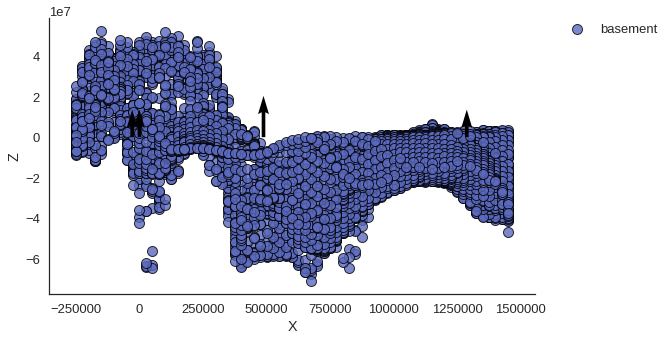

In [38]:
gp.plot_data(geo_data, direction='y')

In [61]:
gp.plot_data_3D(geo_data)

In [39]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True, dtype='float64', theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0


In [49]:
interp_data.interpolator.tg.nugget_effect_scalar_T.set_value(1e-06)

In [50]:
lith, fault = gp.compute_model(interp_data)

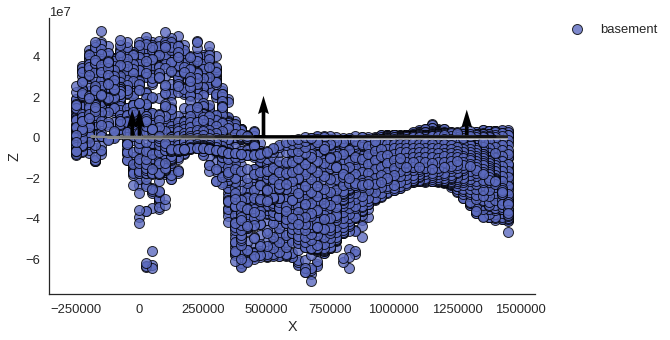

In [51]:
gp.plot_scalar_field(geo_data, lith[1], 10
                    )

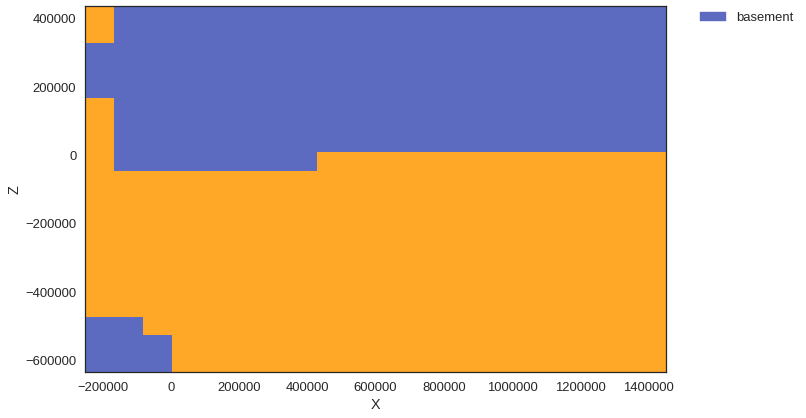

In [52]:
gp.plot_section(geo_data, lith[0],10)

In [53]:
ver, sim = gp.get_surfaces(interp_data, lith[1], None, original_scale=False)

In [54]:
gp.plot_surfaces_3D_real_time(interp_data, ver, sim, plot_data=False)

# Relative extrema

In [12]:
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import pandas as pn
import numpy as np
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

In [13]:
raw_data = pn.read_csv('Argentina/Data/Crust.xyz', sep='\t', header=None)

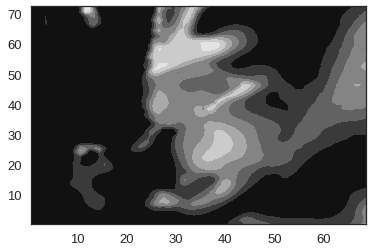

In [79]:
xvals = np.unique(raw_data[0])
yvals = np.unique(raw_data[1]) # Required later on
data_arr = raw_data[2].values.reshape(-1, xvals.shape[0])
%matplotlib inline
plt.contourf(data_arr, origin='upper')

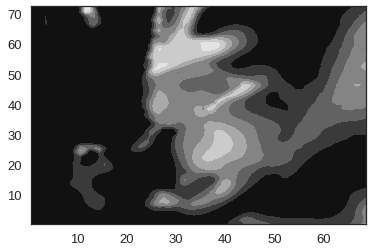

In [15]:
# Modeling Bouguer, therefore if z > 0: z:=0
data_arr[data_arr>0] = 0
data_arr.max()
plt.contourf(data_arr, origin='upper')

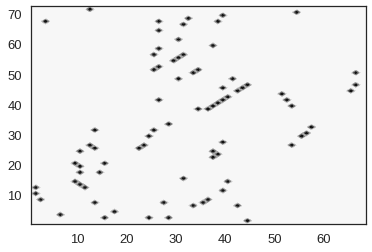

In [98]:
# Compute local minima

# x-direction
idy_minX, idx_minX = argrelextrema(data_arr, np.less, axis=1)
data_minX = np.zeros_like(data_arr)
data_minX[idy_minX, idx_minX] = 1

# y-direction
idy_minY, idx_minY = argrelextrema(data_arr, np.less, axis=0)
data_minY = np.zeros_like(data_arr)
data_minY[idy_minY, idx_minY] = 1

if False:
    plt.figure()
    plt.title('Minima in x-direction')
    plt.contourf(data_minX, origin='upper')
    plt.figure()
    plt.title('Minima in y-direction')
    plt.contourf(data_minY, origin='upper')

# Join directional minima to bidirectional minima
data_min = data_minX + data_minY
data_min[data_min==1] = 0
if True:
    plt.contourf(data_min, origin='upper')

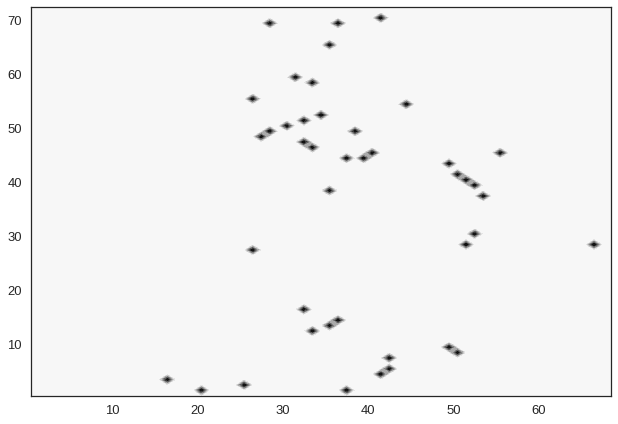

In [120]:
# Compute local maxima
# x-direction
idy_maxX, idx_maxX = argrelextrema(data_arr, np.greater, axis=1)
data_maxX = np.zeros_like(data_arr)
data_maxX[idy_maxX, idx_maxX] = 1

# y-direction
idy_maxY, idx_maxY = argrelextrema(data_arr, np.greater, axis=0)
data_maxY = np.zeros_like(data_arr)
data_maxY[idy_maxY, idx_maxY] = 1

# Join the directional maxima to bidirectional maxima
data_max = data_maxX + data_maxY
data_max[data_max==1] = 0
if True:
    plt.contourf(data_max, origin='upper')

In [123]:
np.max(data_min)

2.0

In [124]:
# Transfer back to XYZ table
# maxima
data_max_indices = np.indices(data_max.shape)
indices_max_y = data_max_indices[0][data_max==2]
indices_max_x = data_max_indices[1][data_max==2]
# minima
data_min_indices = np.indices(data_min.shape)
indices_min_y = data_min_indices[0][data_min==2]
indices_min_x = data_min_indices[1][data_min==2]

In [125]:
gp_in_x = []
gp_in_y = []
gp_in_z = []
for i in range(indices_max_y.shape[0]):
    pidx_x = indices_max_x[i]
    pidx_y = indices_max_y[i]
    gp_in_z.append(data_arr[pidx_y][pidx_x])
    gp_in_x.append(xvals[pidx_x])
    gp_in_y.append(yvals[pidx_y])
for i in range(indices_min_y.shape[0]):
    pidx_x = indices_min_x[i]
    pidx_y = indices_min_y[i]
    gp_in_z.append(data_arr[pidx_y][pidx_x])
    gp_in_x.append(xvals[pidx_x])
    gp_in_y.append(yvals[pidx_y])

In [130]:
# Create the gempy model
xmin = np.min(raw_data[0])
xmax = np.max(raw_data[0])
ymin = np.min(raw_data[1])
ymax = np.max(raw_data[1])
zmin = np.min(raw_data[2])
zmin = np.floor(zmin/1000)*1000
zmax = 0
nx = int((xmax - xmin)/25000)
ny = int((ymax - ymin)/25000)
nz = int((zmax - zmin)/500)
extent = [xmin, xmax, ymin, ymax, zmin, zmax]
resolution = [nx, ny, nz]
geo_data = gp.create_data(extent, resolution)

In [131]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,X_std,Y_std,Z_std,dip_std,azimuth_std,order_series,isFault,formation_number,annotations


In [132]:
a = pn.DataFrame(data=np.array([gp_in_x, gp_in_y, gp_in_z]).T,
             columns=['X', 'Y', 'Z'])
a['formation'] = 'Default'
gp.set_interfaces(geo_data, a)

In [133]:
gp.plot_data_3D(geo_data)

In [134]:
gp.data_to_pickle(geo_data)